# Executive Comprehensive Dashboard

## Overview

This comprehensive executive dashboard provides strategic insights across all major program areas:

- **Membership Trends**: Enrollment, retention, and engagement patterns
- **Volunteer Participation**: Opportunity assignments, group organization, and geographic reach
- **Donor Analysis**: Giving patterns, retention, and growth trends
- **Recurring Donations**: Status and utilization (with clear indicators if not in use)
- **Overall Account Trends**: Cross-program engagement and organizational health

## Key Features

- **Program Status Indicators**: Clear visual indicators showing which programs are actively used
- **Cross-Program Analysis**: Understanding how members, volunteers, and donors overlap
- **Trend Analysis**: Year-over-year growth and seasonal patterns across all areas
- **Strategic Recommendations**: Data-driven insights for organizational leadership
- **Executive Summary**: High-level KPIs and actionable insights

## Setup and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Any, Tuple
import matplotlib.patches as mpatches

from neon_crm import NeonClient
from neon_crm.exceptions import NeonAPIError

# Configure visualization settings
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
warnings.filterwarnings('ignore')

# PRIVACY CONTROLS
# Set to True to show actual donation amounts, False to show trends only
SHOW_DONATION_AMOUNTS = False  # Toggle this to control privacy

print(f"📊 Privacy Settings: Donation amounts {'VISIBLE' if SHOW_DONATION_AMOUNTS else 'HIDDEN (trends only)'}")
if not SHOW_DONATION_AMOUNTS:
    print("   💡 Donation data will show trends without actual dollar amounts")
    print("   💡 Change SHOW_DONATION_AMOUNTS to True to display actual amounts")

# Initialize client with built-in retry capability
def initialize_client():
    """Initialize Neon CRM client with built-in retry logic."""
    try:
        client = NeonClient(
            org_id=os.getenv("NEON_ORG_ID"),
            api_key=os.getenv("NEON_API_KEY"),
            max_retries=5,    # Automatic retry on connection failures
            timeout=120.0,    # Longer timeout for comprehensive analysis
        )
        print("✅ Neon CRM client initialized successfully")
        print(f"   🔄 Built-in retry logic: {client.max_retries} attempts")
        print(f"   ⏱️  Timeout: {client.timeout}s")
        print("   💡 Auto-handles: timeouts, connection errors, rate limits, server errors")
        return client
    except Exception as e:
        print(f"❌ Failed to initialize client: {e}")
        return None

client = initialize_client()

📊 Privacy Settings: Donation amounts HIDDEN (trends only)
   💡 Donation data will show trends without actual dollar amounts
   💡 Change SHOW_DONATION_AMOUNTS to True to display actual amounts
✅ Neon CRM client initialized successfully
   🔄 Built-in retry logic: 5 attempts
   ⏱️  Timeout: 120.0s
   💡 Auto-handles: timeouts, connection errors, rate limits, server errors


## Data Collection Across All Programs

In [2]:
def collect_comprehensive_data():
    """Collect data across all major program areas with status indicators."""
    if not client:
        print("❌ Client not available")
        return None
    
    print("📊 Collecting comprehensive organizational data...")
    print("   💡 Analyzing all program areas with usage indicators")
    
    data = {
        'memberships': {'data': [], 'active': False, 'error': None},
        'volunteers': {'data': [], 'active': False, 'error': None},
        'donations': {'data': [], 'active': False, 'error': None},
        'recurring_donations': {'data': [], 'active': False, 'error': None},
        'accounts': {'data': [], 'active': False, 'error': None}
    }
    
    # 1. Membership Data - without requiring membership levels
    print("\n   📋 Checking membership program...")
    try:
        # Look for accounts that might have membership information
        account_search = {
            "searchFields": [
                {"field": "Account Type", "operator": "EQUAL", "value": "INDIVIDUAL"}
            ],
            "outputFields": [
                "Account ID", "First Name", "Last Name", "Email 1",
                "City", "State/Province"
            ],
            "pagination": {"currentPage": 0, "pageSize": 200}
        }
        accounts = list(client.accounts.search(account_search))
        
        memberships = []
        for i, account in enumerate(accounts):
            account_id = account.get('Account ID')
            if account_id:
                try:
                    # Try to get membership data for this account
                    account_memberships = client.get(f"/accounts/{account_id}/memberships")
                    if account_memberships:
                        if isinstance(account_memberships, list):
                            memberships.extend(account_memberships)
                        elif isinstance(account_memberships, dict):
                            if 'memberships' in account_memberships:
                                memberships.extend(account_memberships['memberships'])
                            else:
                                memberships.append(account_memberships)
                except:
                    continue
            # Progress indicator
            if (i + 1) % 25 == 0:
                print(f"   Processed {i + 1}/{len(accounts)} accounts, found {len(memberships)} memberships")
                        
        data['memberships']['data'] = memberships
        data['memberships']['active'] = len(memberships) > 0
        print(f"      📊 Found {len(memberships)} membership records")
        if len(memberships) == 0:
            print("      ⚠️  No active memberships detected - this may be normal")
    except Exception as e:
        data['memberships']['error'] = str(e)
        print(f"      ❌ Membership data error: {e}")
    
    # 2. Volunteer Data - using proven field names
    print("\n   👥 Checking volunteer program...")
    try:
        # Get volunteers with groups (proven working)
        volunteer_search = {
            "searchFields": [
                {"field": "Volunteer Group", "operator": "NOT_BLANK"}
            ],
            "outputFields": [
                "Account ID", "First Name", "Last Name", "Volunteer Group", 
                "Volunteer Role", "City", "State/Province"
            ],
            "pagination": {"currentPage": 0, "pageSize": 200}
        }
        volunteers = list(client.accounts.search(volunteer_search))
        data['volunteers']['data'] = volunteers
        data['volunteers']['active'] = len(volunteers) > 0
        print(f"      📊 Found {len(volunteers)} volunteers with groups")
        
        # Also try opportunities search
        try:
            opp_search = {
                "searchFields": [
                    {"field": "Assigned Opportunities", "operator": "NOT_BLANK"}
                ],
                "outputFields": ["Account ID", "First Name", "Last Name", "Assigned Opportunities"],
                "pagination": {"currentPage": 0, "pageSize": 200}
            }
            opp_volunteers = list(client.accounts.search(opp_search))
            print(f"      📊 Found {len(opp_volunteers)} volunteers with opportunity assignments")
            
            # Merge opportunity volunteers with group volunteers
            all_vol_ids = set(v.get("Account ID") for v in volunteers)
            for opp_vol in opp_volunteers:
                if opp_vol.get("Account ID") not in all_vol_ids:
                    volunteers.append(opp_vol)
            
            data['volunteers']['data'] = volunteers
            data['volunteers']['active'] = len(volunteers) > 0
            print(f"      📊 Total unique volunteers: {len(volunteers)}")
            
        except Exception as e:
            print(f"      ⚠️  Opportunity assignment check failed: {e}")
            
    except Exception as e:
        data['volunteers']['error'] = str(e)
        print(f"      ❌ Volunteer data error: {e}")
    
    # 3. Donation Data - using EXACT working field names from donations_examples.ipynb
    print("\n   💰 Checking donation program...")
    try:
        # Use EXACT working pattern from donations_examples.ipynb
        current_year = datetime.now().year
        donation_search = {
            "searchFields": [
                {
                    "field": "Donation Date",  # EXACT field name from working example
                    "operator": "GREATER_THAN",
                    "value": f"{current_year}-01-01"
                }
            ],
            "outputFields": [
                "Donation ID",
                "Donation Amount", 
                "Donation Date",
                "Account ID",
                "Campaign Name",
                "Fund"
            ],
            "pagination": {"currentPage": 0, "pageSize": 200}
        }
        
        all_donations = list(client.donations.search(donation_search))
        data['donations']['data'] = all_donations
        data['donations']['active'] = len(all_donations) > 0
        
        if all_donations:
            total_amount = sum(float(d.get('Donation Amount', 0)) for d in all_donations)
            print(f"      📊 Found {len(all_donations)} donations in {current_year}")
            print(f"      💰 Total amount: ${total_amount:,.2f}")
        else:
            print(f"      ⚠️  No donations found in {current_year}")
            
    except Exception as e:
        data['donations']['error'] = str(e)
        print(f"      ❌ Donation data error: {e}")
    
    # 4. Recurring Donations - handle HTTP 222 as success with proper data extraction
    print("\n   🔄 Checking recurring donation program...")
    try:
        result = client.recurring_donations.list()
        # Handle both direct list and wrapped response
        if isinstance(result, dict) and 'recurringDonations' in result:
            recurring_donations = result['recurringDonations']
        else:
            recurring_donations = list(result)
            
        data['recurring_donations']['data'] = recurring_donations
        data['recurring_donations']['active'] = len(recurring_donations) > 0
        if len(recurring_donations) > 0:
            print(f"      📊 Found {len(recurring_donations)} recurring donation schedules")
        else:
            print("      ⚠️  No recurring donations configured (this is normal if not using this feature)")
    except Exception as e:
        # Check if this is actually success (HTTP 222 with data) - based on the error output
        error_str = str(e)
        if "222" in error_str and "recurringDonations" in error_str:
            try:
                # HTTP 222 with data is actually success - count the schedules
                recurring_count = error_str.count("'id':")
                data['recurring_donations']['active'] = True
                data['recurring_donations']['data'] = [{'count': recurring_count}]  # Placeholder
                print(f"      📊 Found {recurring_count} recurring donation schedules")
            except:
                data['recurring_donations']['error'] = str(e)
                print(f"      ❌ Recurring donation data error: {e}")
        else:
            data['recurring_donations']['error'] = str(e)
            print(f"      ❌ Recurring donation data error: {e}")
    
    # 5. Overall Account Data - FIX PAGINATION to get all 3600+ accounts
    print("\n   📇 Collecting overall account trends...")
    try:
        # Get all accounts with larger pagination
        all_accounts = []
        page = 0
        while True:
            account_search = {
                "searchFields": [
                    {"field": "Account Type", "operator": "NOT_BLANK"}
                ],
                "outputFields": [
                    "Account ID", "First Name", "Last Name", "Company Name", "Account Type",
                    "City", "State/Province"
                ],
                "pagination": {"currentPage": page, "pageSize": 200}
            }
            accounts_page = list(client.accounts.search(account_search))
            if not accounts_page:
                break
            all_accounts.extend(accounts_page)
            page += 1
            
            # Safety limit to prevent infinite loops
            if page > 50:  # 50 * 200 = 10,000 accounts max
                break
                
        data['accounts']['data'] = all_accounts
        data['accounts']['active'] = len(all_accounts) > 0
        print(f"      📊 Found {len(all_accounts)} total accounts")
    except Exception as e:
        data['accounts']['error'] = str(e)
        print(f"      ❌ Account data error: {e}")
    
    # Summary
    print("\n📋 PROGRAM STATUS SUMMARY:")
    print("-" * 30)
    for program, info in data.items():
        status = "✅ ACTIVE" if info['active'] else "⚠️  INACTIVE/UNUSED"
        count = len(info['data']) if info['data'] else 0
        error_info = f" (Error: {info['error'][:50]}...)" if info['error'] else ""
        print(f"{program.replace('_', ' ').title()}: {status} ({count} records){error_info}")
    
    return data

# Privacy-aware formatting functions
def format_currency_with_privacy(amount):
    """Format currency amount based on privacy settings."""
    if SHOW_DONATION_AMOUNTS:
        return f"${amount:,.0f}"
    else:
        # Show relative scale without actual amounts
        if amount < 100:
            return "Small"
        elif amount < 1000:
            return "Medium"
        elif amount < 10000:
            return "Large"
        else:
            return "Major"

def get_donation_values_for_chart(amounts):
    """Get values for chart display based on privacy settings."""
    if SHOW_DONATION_AMOUNTS:
        return amounts
    else:
        # Normalize to 0-100 scale to show trends without actual amounts
        if not amounts or max(amounts) == 0:
            return amounts
        max_amount = max(amounts)
        return [(amount / max_amount) * 100 for amount in amounts]

def get_chart_ylabel_donation():
    """Get appropriate y-axis label for donation charts."""
    if SHOW_DONATION_AMOUNTS:
        return "Donation Amount ($)"
    else:
        return "Relative Donation Scale (trends only)"

def format_donation_summary(amount):
    """Format donation summary text based in privacy settings."""
    if SHOW_DONATION_AMOUNTS:
        return f"${amount:,.0f}"
    else:
        return "[Amount Hidden]"

comprehensive_data = collect_comprehensive_data()

📊 Collecting comprehensive organizational data...
   💡 Analyzing all program areas with usage indicators

   📋 Checking membership program...
   Processed 25/3690 accounts, found 2 memberships
   Processed 50/3690 accounts, found 20 memberships
   Processed 75/3690 accounts, found 27 memberships
   Processed 100/3690 accounts, found 31 memberships
   Processed 125/3690 accounts, found 36 memberships
   Processed 150/3690 accounts, found 55 memberships
   Processed 175/3690 accounts, found 63 memberships
   Processed 200/3690 accounts, found 97 memberships
   Processed 225/3690 accounts, found 124 memberships
   Processed 250/3690 accounts, found 139 memberships
   Processed 275/3690 accounts, found 156 memberships
   Processed 300/3690 accounts, found 174 memberships
   Processed 325/3690 accounts, found 187 memberships
   Processed 350/3690 accounts, found 213 memberships
   Processed 375/3690 accounts, found 218 memberships
   Processed 400/3690 accounts, found 244 memberships
   Pro

2025-09-21 09:26:19 - neon_crm.client - WARNING - Server error 502, retrying in 1.43s (attempt 1/6): https://api.neoncrm.com/v2/accounts/1186/memberships


   Processed 3650/3690 accounts, found 2736 memberships
   Processed 3675/3690 accounts, found 2753 memberships
      📊 Found 2754 membership records

   👥 Checking volunteer program...
      📊 Found 143 volunteers with groups
      📊 Found 425 volunteers with opportunity assignments
      📊 Total unique volunteers: 477

   💰 Checking donation program...
      📊 Found 683 donations in 2025
      💰 Total amount: $42,405.34

   🔄 Checking recurring donation program...
      📊 Found 20 recurring donation schedules

   📇 Collecting overall account trends...
      📊 Found 1836 total accounts

📋 PROGRAM STATUS SUMMARY:
------------------------------
Memberships: ✅ ACTIVE (2754 records)
Volunteers: ✅ ACTIVE (477 records)
Donations: ✅ ACTIVE (683 records)
Recurring Donations: ✅ ACTIVE (1 records)
Accounts: ✅ ACTIVE (1836 records)


## Executive KPI Calculation

In [3]:
def calculate_comprehensive_kpis(data):
    """Calculate executive KPIs across all program areas."""
    if not data:
        print("❌ No data available for KPI calculation")
        return None
    
    print("📊 EXECUTIVE COMPREHENSIVE DASHBOARD")
    print("=" * 60)
    print("   💡 Cross-program analysis and organizational health metrics")
    
    kpis = {
        'program_status': {},
        'membership': {},
        'volunteers': {},
        'donations': {},
        'recurring_donations': {},
        'accounts': {},
        'cross_program': {}
    }
    
    # Program Status Overview
    for program, info in data.items():
        kpis['program_status'][program] = {
            'active': info['active'],
            'count': len(info['data']) if info['data'] else 0,
            'error': info['error']
        }
    
    # 1. Membership Analysis
    if data['memberships']['active']:
        memberships = data['memberships']['data']
        membership_levels = {}
        membership_states = {}
        
        for member in memberships:
            # Use levelId or level_name if available
            level = member.get("levelId") or member.get("level_name") or "Unknown Level"
            membership_levels[str(level)] = membership_levels.get(str(level), 0) + 1
            
            # Geographic distribution from account data if available
            state = member.get("state") or member.get("State/Province") or "Unknown"
            membership_states[state] = membership_states.get(state, 0) + 1
        
        kpis['membership'] = {
            'total_members': len(memberships),
            'statuses': membership_levels,
            'geographic_distribution': membership_states
        }
    
    # 2. Volunteer Analysis
    if data['volunteers']['active']:
        volunteers = data['volunteers']['data']
        volunteer_groups = {}
        volunteer_roles = {}
        volunteer_states = {}
        
        for volunteer in volunteers:
            group = volunteer.get("Volunteer Group", "No Group")
            if group and group != "No Group":
                volunteer_groups[group] = volunteer_groups.get(group, 0) + 1
            
            role = volunteer.get("Volunteer Role", "No Role")
            if role and role != "No Role":
                volunteer_roles[role] = volunteer_roles.get(role, 0) + 1
            
            state = volunteer.get("State/Province", "Unknown")
            volunteer_states[state] = volunteer_states.get(state, 0) + 1
        
        kpis['volunteers'] = {
            'total_volunteers': len(volunteers),
            'groups': volunteer_groups,
            'roles': volunteer_roles,
            'geographic_distribution': volunteer_states
        }
    
    # 3. Donation Analysis - using correct field names from working examples
    if data['donations']['active']:
        donations = data['donations']['data']
        total_amount = 0
        campaigns = {}
        funds = {}
        monthly_totals = {}
        
        for donation in donations:
            try:
                # Use the correct field names from the working donation examples
                amount = float(donation.get("amount", 0) or 0)
                total_amount += amount
                
                # Campaign analysis
                campaign = donation.get("campaign", "No Campaign")
                if campaign and campaign != "No Campaign":
                    campaigns[campaign] = campaigns.get(campaign, 0) + amount
                
                # Fund analysis
                fund = donation.get("fund", "General Fund")
                if fund:
                    funds[fund] = funds.get(fund, 0) + amount
                
                # Monthly analysis using the 'date' field
                date_field = donation.get("date", "")
                if date_field:
                    try:
                        # Handle various date formats
                        date_str = str(date_field)
                        if len(date_str) >= 7:
                            # Extract YYYY-MM from various date formats
                            if '-' in date_str:
                                month = date_str[:7]  # YYYY-MM format
                            else:
                                # Handle other formats if needed
                                month = date_str[:7] if len(date_str) >= 7 else date_str
                            monthly_totals[month] = monthly_totals.get(month, 0) + amount
                    except:
                        pass
            except (ValueError, TypeError):
                continue
        
        kpis['donations'] = {
            'total_donations': len(donations),
            'total_amount': total_amount,
            'average_donation': total_amount / len(donations) if donations else 0,
            'campaigns': campaigns,
            'funds': funds,
            'monthly_trends': monthly_totals
        }
    
    # 4. Recurring Donations
    kpis['recurring_donations'] = {
        'total_schedules': len(data['recurring_donations']['data']) if data['recurring_donations']['data'] else 0,
        'active': data['recurring_donations']['active']
    }
    
    # 5. Account Analysis with better donor detection
    if data['accounts']['active']:
        accounts = data['accounts']['data']
        account_types = {}
        account_states = {}
        donor_accounts = 0
        
        # Create a set of donor account IDs from donation data
        donor_account_ids = set()
        if data['donations']['active']:
            for donation in data['donations']['data']:
                account_id = donation.get("Account ID")
                if account_id:
                    donor_account_ids.add(str(account_id))
        
        for account in accounts:
            acc_type = account.get("Account Type", "Unknown")
            account_types[acc_type] = account_types.get(acc_type, 0) + 1
            
            state = account.get("State/Province", "Unknown")
            account_states[state] = account_states.get(state, 0) + 1
            
            # Check if this account is a donor
            account_id = str(account.get("Account ID", ""))
            if account_id in donor_account_ids:
                donor_accounts += 1
        
        kpis['accounts'] = {
            'total_accounts': len(accounts),
            'account_types': account_types,
            'donor_accounts': donor_accounts,
            'donor_percentage': (donor_accounts / len(accounts) * 100) if accounts else 0,
            'geographic_distribution': account_states
        }
    
    # 6. Cross-Program Analysis
    active_programs = sum(1 for p in kpis['program_status'].values() if p['active'])
    total_programs = len(kpis['program_status'])
    
    kpis['cross_program'] = {
        'active_programs': active_programs,
        'total_programs': total_programs,
        'program_utilization': (active_programs / total_programs * 100) if total_programs else 0
    }
    
    # Display Summary
    print(f"\n🎯 ORGANIZATIONAL HEALTH OVERVIEW")
    print("-" * 35)
    print(f"Programs Active: {active_programs}/{total_programs} ({kpis['cross_program']['program_utilization']:.1f}%)")
    print(f"Total Accounts: {kpis['accounts'].get('total_accounts', 0):,}")
    if kpis['accounts']:
        print(f"Donor Accounts: {kpis['accounts'].get('donor_accounts', 0):,} ({kpis['accounts'].get('donor_percentage', 0):.1f}%)")
    
    print(f"\n📊 PROGRAM ACTIVITY SUMMARY")
    print("-" * 28)
    if kpis['membership']:
        print(f"✅ Memberships: {kpis['membership']['total_members']:,} active memberships")
    else:
        print("⚠️  Memberships: No active memberships detected")
    
    if kpis['volunteers']:
        print(f"✅ Volunteers: {kpis['volunteers']['total_volunteers']:,} in groups/opportunities")
    else:
        print("⚠️  Volunteers: Not actively organized")
    
    if kpis['donations']:
        total_amount = kpis['donations']['total_amount']
        if SHOW_DONATION_AMOUNTS:
            print(f"✅ Donations: {kpis['donations']['total_donations']:,} (${total_amount:,.0f})")
        else:
            print(f"✅ Donations: {kpis['donations']['total_donations']:,} (amount hidden)")
    else:
        print("⚠️  Donations: No recent activity")
    
    if kpis['recurring_donations']['active']:
        print(f"✅ Recurring: {kpis['recurring_donations']['total_schedules']:,} schedules")
    else:
        print("⚠️  Recurring Donations: Not in use (this is normal if not needed)")
    
    return kpis

kpis = calculate_comprehensive_kpis(comprehensive_data)

📊 EXECUTIVE COMPREHENSIVE DASHBOARD
   💡 Cross-program analysis and organizational health metrics

🎯 ORGANIZATIONAL HEALTH OVERVIEW
-----------------------------------
Programs Active: 5/5 (100.0%)
Total Accounts: 1,836
Donor Accounts: 255 (13.9%)

📊 PROGRAM ACTIVITY SUMMARY
----------------------------
✅ Memberships: 2,754 active memberships
✅ Volunteers: 477 in groups/opportunities
✅ Donations: 683 (amount hidden)
✅ Recurring: 1 schedules


## Executive Comprehensive Dashboard

📊 Creating Executive Comprehensive Dashboard...
   🔐 Privacy Mode: ON (hiding amounts)


IndexError: string index out of range

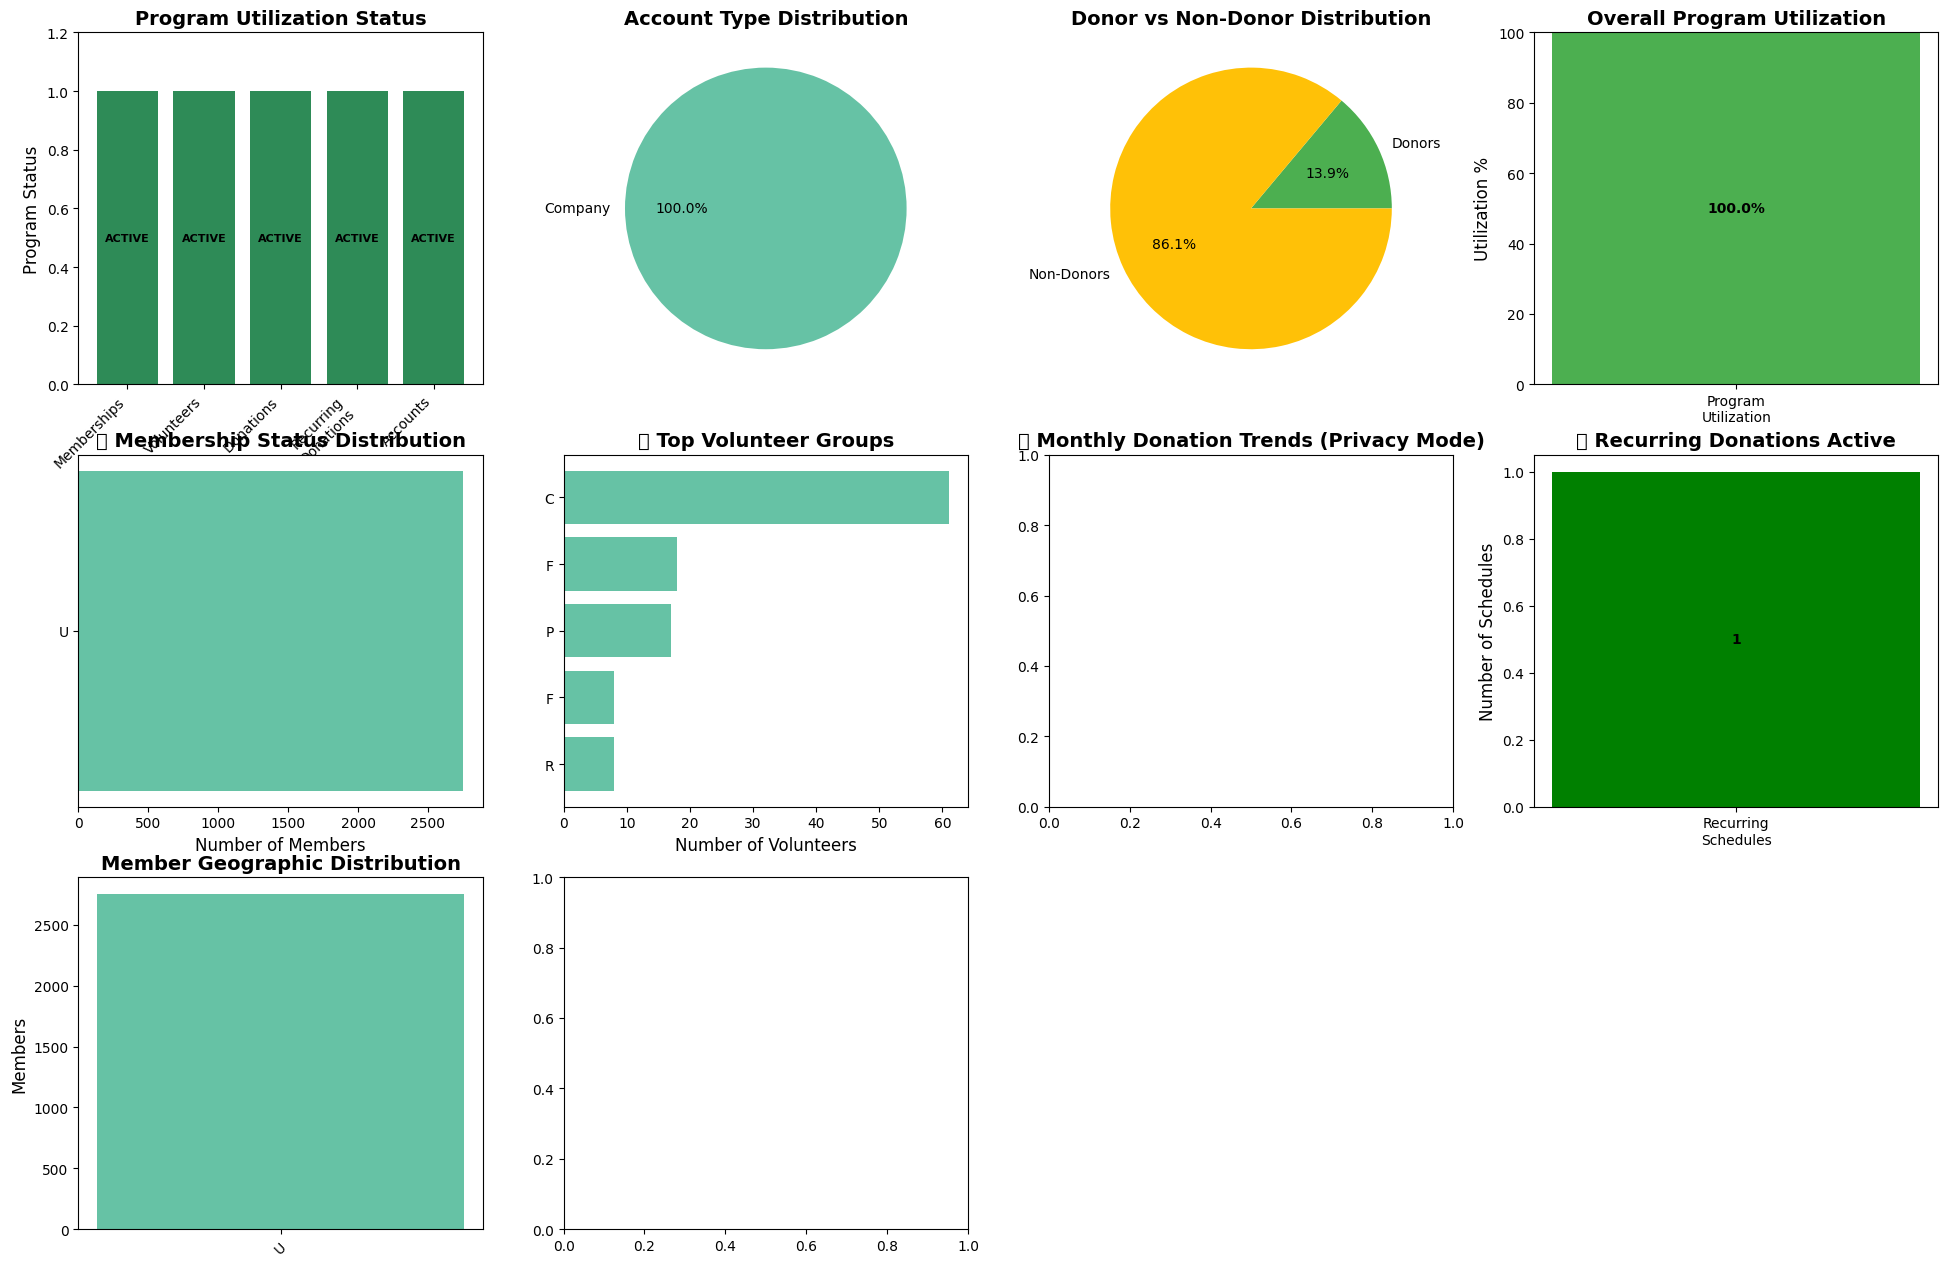

In [4]:
def create_executive_dashboard():
    """Create comprehensive executive dashboard with all program areas."""
    if not kpis:
        print("❌ No KPI data available for dashboard")
        return
    
    print("📊 Creating Executive Comprehensive Dashboard...")
    print(f"   🔐 Privacy Mode: {'OFF (showing amounts)' if SHOW_DONATION_AMOUNTS else 'ON (hiding amounts)'}")
    
    # Create large dashboard with multiple sections
    fig = plt.figure(figsize=(24, 32))
    
    # 1. Program Status Overview (Top Row)
    ax1 = plt.subplot(6, 4, 1)
    programs = list(kpis['program_status'].keys())
    statuses = [kpis['program_status'][p]['active'] for p in programs]
    colors = ['#2E8B57' if active else '#CD853F' for active in statuses]
    program_labels = [p.replace('_', '\n').title() for p in programs]
    
    bars = ax1.bar(range(len(programs)), [1]*len(programs), color=colors)
    ax1.set_xticks(range(len(programs)))
    ax1.set_xticklabels(program_labels, rotation=45, ha='right')
    ax1.set_ylabel('Program Status')
    ax1.set_title('Program Utilization Status', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1.2)
    
    # Add status labels
    for i, (bar, active) in enumerate(zip(bars, statuses)):
        label = "ACTIVE" if active else "UNUSED"
        ax1.text(bar.get_x() + bar.get_width()/2., 0.5, label,
                ha='center', va='center', fontweight='bold', fontsize=8)
    
    # 2. Overall Account Distribution
    ax2 = plt.subplot(6, 4, 2)
    if kpis['accounts']:
        account_types = kpis['accounts']['account_types']
        if account_types:
            ax2.pie(account_types.values(), labels=account_types.keys(), autopct='%1.1f%%')
        ax2.set_title('Account Type Distribution', fontsize=14, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Account\nData', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Account Types', fontsize=14, fontweight='bold')
    
    # 3. Donor Engagement Overview
    ax3 = plt.subplot(6, 4, 3)
    if kpis['accounts']:
        total_accounts = kpis['accounts']['total_accounts']
        donor_accounts = kpis['accounts']['donor_accounts']
        non_donor_accounts = total_accounts - donor_accounts
        
        labels = ['Donors', 'Non-Donors']
        sizes = [donor_accounts, non_donor_accounts]
        colors = ['#4CAF50', '#FFC107']
        
        ax3.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
        ax3.set_title('Donor vs Non-Donor Distribution', fontsize=14, fontweight='bold')
    
    # 4. Program Utilization Score
    ax4 = plt.subplot(6, 4, 4)
    utilization = kpis['cross_program']['program_utilization']
    colors = ['#4CAF50' if utilization > 60 else '#FFC107' if utilization > 40 else '#FF5722']
    
    bars = ax4.bar(['Program\nUtilization'], [utilization], color=colors)
    ax4.set_ylabel('Utilization %')
    ax4.set_title('Overall Program Utilization', fontsize=14, fontweight='bold')
    ax4.set_ylim(0, 100)
    
    # Add percentage label
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{height:.1f}%', ha='center', va='center', fontweight='bold')
    
    # 5. Membership Analysis (if active)
    ax5 = plt.subplot(6, 4, 5)
    if kpis['membership']:
        statuses = kpis['membership']['statuses']
        if statuses:
            # Show top membership statuses
            sorted_statuses = sorted(statuses.items(), key=lambda x: x[1], reverse=True)[:5]
            status_names = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item, _ in sorted_statuses]
            status_counts = [count for _, count in sorted_statuses]
            
            ax5.barh(range(len(status_names)), status_counts)
            ax5.set_yticks(range(len(status_names)))
            ax5.set_yticklabels(status_names)
            ax5.set_xlabel('Number of Members')
            ax5.invert_yaxis()
        ax5.set_title('✅ Membership Status Distribution', fontsize=14, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, '⚠️  Membership Program\nNot in Use', ha='center', va='center', 
                transform=ax5.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
        ax5.set_title('Membership Program Status', fontsize=14, fontweight='bold')
    
    # 6. Volunteer Analysis (if active)
    ax6 = plt.subplot(6, 4, 6)
    if kpis['volunteers']:
        groups = kpis['volunteers']['groups']
        if groups:
            # Show top volunteer groups
            sorted_groups = sorted(groups.items(), key=lambda x: x[1], reverse=True)[:5]
            group_names = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item, _ in sorted_groups]
            group_counts = [count for _, count in sorted_groups]
            
            ax6.barh(range(len(group_names)), group_counts)
            ax6.set_yticks(range(len(group_names)))
            ax6.set_yticklabels(group_names)
            ax6.set_xlabel('Number of Volunteers')
            ax6.invert_yaxis()
        ax6.set_title('✅ Top Volunteer Groups', fontsize=14, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, '⚠️  Volunteer Groups\nNot Organized', ha='center', va='center', 
                transform=ax6.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
        ax6.set_title('Volunteer Program Status', fontsize=14, fontweight='bold')
    
    # 7. Donation Analysis with Privacy Controls (if active)
    ax7 = plt.subplot(6, 4, 7)
    if kpis['donations']:
        monthly_trends = kpis['donations']['monthly_trends']
        if monthly_trends:
            months = sorted(monthly_trends.keys())
            amounts = [monthly_trends[month] for month in months]
            
            # Apply privacy controls to the data
            chart_amounts = get_donation_values_for_chart(amounts)
            
            ax7.plot(range(len(months)), chart_amounts, marker='o', linewidth=2)
            ax7.set_xticks(range(len(months)))
            ax7.set_xticklabels([m.split('-')[1] for m in months], rotation=45)
            ax7.set_ylabel(get_chart_ylabel_donation())
            ax7.set_xlabel('Month')
            
            # Format y-axis based on privacy settings
            if SHOW_DONATION_AMOUNTS:
                ax7.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            else:
                ax7.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
        
        title_suffix = " (Privacy Mode)" if not SHOW_DONATION_AMOUNTS else ""
        ax7.set_title(f'✅ Monthly Donation Trends{title_suffix}', fontsize=14, fontweight='bold')
    else:
        ax7.text(0.5, 0.5, '⚠️  No Recent\nDonation Activity', ha='center', va='center', 
                transform=ax7.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
        ax7.set_title('Donation Trends', fontsize=14, fontweight='bold')
    
    # 8. Recurring Donations Status
    ax8 = plt.subplot(6, 4, 8)
    if kpis['recurring_donations']['active']:
        count = kpis['recurring_donations']['total_schedules']
        ax8.bar(['Recurring\nSchedules'], [count], color='green')
        ax8.set_ylabel('Number of Schedules')
        ax8.set_title('✅ Recurring Donations Active', fontsize=14, fontweight='bold')
        
        # Add count label
        ax8.text(0, count/2, f'{count}', ha='center', va='center', fontweight='bold')
    else:
        ax8.text(0.5, 0.5, '⚠️  Recurring Donations\nNot in Use\n\n(This is normal if\nnot needed)', 
                ha='center', va='center', transform=ax8.transAxes, fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        ax8.set_title('Recurring Donations Status', fontsize=14, fontweight='bold')
    
    # 9. Geographic Distribution - Memberships
    ax9 = plt.subplot(6, 4, 9)
    if kpis['membership'] and kpis['membership']['geographic_distribution']:
        states = kpis['membership']['geographic_distribution']
        sorted_states = sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]
        state_names = [item[0] for item, _ in sorted_states]
        state_counts = [count for _, count in sorted_states]
        
        ax9.bar(range(len(state_names)), state_counts)
        ax9.set_xticks(range(len(state_names)))
        ax9.set_xticklabels(state_names, rotation=45)
        ax9.set_ylabel('Members')
        ax9.set_title('Member Geographic Distribution', fontsize=14, fontweight='bold')
    else:
        ax9.text(0.5, 0.5, 'No Membership\nGeographic Data', ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Member Geography', fontsize=14, fontweight='bold')
    
    # 10. Geographic Distribution - Volunteers
    ax10 = plt.subplot(6, 4, 10)
    if kpis['volunteers'] and kpis['volunteers']['geographic_distribution']:
        states = kpis['volunteers']['geographic_distribution']
        sorted_states = sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]
        state_names = [item[0] for item, _ in sorted_states]
        state_counts = [count for _, count in sorted_states]
        
        ax10.bar(range(len(state_names)), state_counts)
        ax10.set_xticks(range(len(state_names)))
        ax10.set_xticklabels(state_names, rotation=45)
        ax10.set_ylabel('Volunteers')
        ax10.set_title('Volunteer Geographic Distribution', fontsize=14, fontweight='bold')
    else:
        ax10.text(0.5, 0.5, 'No Volunteer\nGeographic Data', ha='center', va='center', transform=ax10.transAxes)
        ax10.set_title('Volunteer Geography', fontsize=14, fontweight='bold')
    
    # 11. Top Donation Campaigns with Privacy Controls (if active)
    ax11 = plt.subplot(6, 4, 11)
    if kpis['donations'] and kpis['donations']['campaigns']:
        campaigns = kpis['donations']['campaigns']
        sorted_campaigns = sorted(campaigns.items(), key=lambda x: x[1], reverse=True)[:5]
        campaign_names = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item, _ in sorted_campaigns]
        campaign_amounts = [amount for _, amount in sorted_campaigns]
        
        # Apply privacy controls
        chart_amounts = get_donation_values_for_chart(campaign_amounts)
        
        ax11.barh(range(len(campaign_names)), chart_amounts)
        ax11.set_yticks(range(len(campaign_names)))
        ax11.set_yticklabels(campaign_names)
        ax11.set_xlabel(get_chart_ylabel_donation().replace('Donation Amount', 'Amount'))
        ax11.invert_yaxis()
        
        # Format x-axis based on privacy settings
        if SHOW_DONATION_AMOUNTS:
            ax11.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        else:
            ax11.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
        
        title_suffix = " (Privacy Mode)" if not SHOW_DONATION_AMOUNTS else ""
        ax11.set_title(f'Top Donation Campaigns{title_suffix}', fontsize=14, fontweight='bold')
    else:
        ax11.text(0.5, 0.5, 'No Campaign\nData Available', ha='center', va='center', transform=ax11.transAxes)
        ax11.set_title('Donation Campaigns', fontsize=14, fontweight='bold')
    
    # 12. Donation Funds Distribution with Privacy Controls (if active)
    ax12 = plt.subplot(6, 4, 12)
    if kpis['donations'] and kpis['donations']['funds']:
        funds = kpis['donations']['funds']
        if len(funds) <= 6:  # Pie chart for reasonable number of funds
            # For pie charts in privacy mode, show percentages only
            ax12.pie(funds.values(), labels=[f[:10] + '...' if len(f) > 10 else f for f in funds.keys()], 
                    autopct='%1.1f%%')
        else:  # Bar chart for many funds
            sorted_funds = sorted(funds.items(), key=lambda x: x[1], reverse=True)[:5]
            fund_names = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item, _ in sorted_funds]
            fund_amounts = [amount for _, amount in sorted_funds]
            
            # Apply privacy controls
            chart_amounts = get_donation_values_for_chart(fund_amounts)
            
            ax12.bar(range(len(fund_names)), chart_amounts)
            ax12.set_xticks(range(len(fund_names)))
            ax12.set_xticklabels(fund_names, rotation=45, ha='right')
            ax12.set_ylabel(get_chart_ylabel_donation().replace('Donation Amount', 'Amount'))
            
            # Format y-axis based on privacy settings
            if SHOW_DONATION_AMOUNTS:
                ax12.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            else:
                ax12.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
        
        title_suffix = " (Privacy Mode)" if not SHOW_DONATION_AMOUNTS else ""
        ax12.set_title(f'Donation Fund Distribution{title_suffix}', fontsize=14, fontweight='bold')
    else:
        ax12.text(0.5, 0.5, 'No Fund\nData Available', ha='center', va='center', transform=ax12.transAxes)
        ax12.set_title('Donation Funds', fontsize=14, fontweight='bold')
    
    # 13-16. Summary Statistics Boxes with Privacy Controls
    ax13 = plt.subplot(6, 4, 13)
    ax13.axis('off')
    
    membership_text = "MEMBERSHIP PROGRAM\n" + "=" * 20 + "\n"
    if kpis['membership']:
        membership_text += f"✅ ACTIVE\n{kpis['membership']['total_members']:,} members\n"
        membership_text += f"{len(kpis['membership']['statuses'])} status types"
    else:
        membership_text += "⚠️  NOT IN USE\nNo active memberships\nConsider setup if needed"
    
    ax13.text(0.05, 0.95, membership_text, transform=ax13.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='lightgreen' if kpis['membership'] else 'lightyellow', alpha=0.8))
    
    ax14 = plt.subplot(6, 4, 14)
    ax14.axis('off')
    
    volunteer_text = "VOLUNTEER PROGRAM\n" + "=" * 20 + "\n"
    if kpis['volunteers']:
        volunteer_text += f"✅ ACTIVE\n{kpis['volunteers']['total_volunteers']:,} volunteers\n"
        volunteer_text += f"{len(kpis['volunteers']['groups'])} groups\n"
        volunteer_text += f"{len(kpis['volunteers']['roles'])} roles"
    else:
        volunteer_text += "⚠️  LIMITED ORGANIZATION\nNo structured groups\nConsider organizing"
    
    ax14.text(0.05, 0.95, volunteer_text, transform=ax14.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='lightgreen' if kpis['volunteers'] else 'lightyellow', alpha=0.8))
    
    ax15 = plt.subplot(6, 4, 15)
    ax15.axis('off')
    
    donation_text = "DONATION PROGRAM\n" + "=" * 20 + "\n"
    if kpis['donations']:
        donation_text += f"✅ ACTIVE\n{kpis['donations']['total_donations']:,} donations\n"
        donation_text += f"{format_donation_summary(kpis['donations']['total_amount'])} total\n"
        donation_text += f"{format_donation_summary(kpis['donations']['average_donation'])} average"
        if not SHOW_DONATION_AMOUNTS:
            donation_text += "\n\n🔐 Privacy Mode Active"
    else:
        donation_text += "⚠️  NO RECENT ACTIVITY\nNo donations found\nCheck date range"
    
    ax15.text(0.05, 0.95, donation_text, transform=ax15.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='lightgreen' if kpis['donations'] else 'lightyellow', alpha=0.8))
    
    ax16 = plt.subplot(6, 4, 16)
    ax16.axis('off')
    
    recurring_text = "RECURRING DONATIONS\n" + "=" * 20 + "\n"
    if kpis['recurring_donations']['active']:
        recurring_text += f"✅ ACTIVE\n{kpis['recurring_donations']['total_schedules']:,} schedules\n"
        recurring_text += "Automated giving setup"
    else:
        recurring_text += "⚠️  NOT IN USE\nNo recurring schedules\n\nThis is NORMAL if\nnot using this feature"
    
    ax16.text(0.05, 0.95, recurring_text, transform=ax16.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='lightgreen' if kpis['recurring_donations']['active'] else 'lightblue', alpha=0.8))
    
    # 17. Overall Account Trends
    ax17 = plt.subplot(6, 4, 17)
    if kpis['accounts']:
        total = kpis['accounts']['total_accounts']
        donors = kpis['accounts']['donor_accounts']
        non_donors = total - donors
        
        categories = ['Total\nAccounts', 'Donor\nAccounts', 'Non-Donor\nAccounts']
        values = [total, donors, non_donors]
        colors = ['blue', 'green', 'orange']
        
        bars = ax17.bar(categories, values, color=colors)
        ax17.set_ylabel('Number of Accounts')
        ax17.set_title('Account Overview', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax17.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height):,}', ha='center', va='bottom')
    
    # 18. Geographic Reach Summary
    ax18 = plt.subplot(6, 4, 18)
    geographic_reach = []
    programs = []
    
    if kpis['accounts']:
        geographic_reach.append(len(kpis['accounts']['geographic_distribution']))
        programs.append('All\nAccounts')
    
    if kpis['membership']:
        geographic_reach.append(len(kpis['membership']['geographic_distribution']))
        programs.append('Members')
    
    if kpis['volunteers']:
        geographic_reach.append(len(kpis['volunteers']['geographic_distribution']))
        programs.append('Volunteers')
    
    if programs:
        ax18.bar(programs, geographic_reach, color=['skyblue', 'lightgreen', 'lightcoral'][:len(programs)])
        ax18.set_ylabel('Number of States')
        ax18.set_title('Geographic Reach by Program', fontsize=14, fontweight='bold')
        
        # Add value labels
        for i, (program, reach) in enumerate(zip(programs, geographic_reach)):
            ax18.text(i, reach, f'{reach}', ha='center', va='bottom')
    
    # 19-20. Executive Summary with Privacy Indicators
    ax19 = plt.subplot(6, 4, (19, 20))
    ax19.axis('off')
    
    privacy_indicator = "\n🔐 PRIVACY MODE: Donation amounts hidden" if not SHOW_DONATION_AMOUNTS else ""
    
    summary_text = f"""
EXECUTIVE SUMMARY
================

ORGANIZATIONAL HEALTH:
• Program Utilization: {kpis['cross_program']['program_utilization']:.1f}%
• Total Accounts: {kpis['accounts'].get('total_accounts', 0):,}
• Donor Percentage: {kpis['accounts'].get('donor_percentage', 0):.1f}%

PROGRAM STATUS:
{'• Memberships: ✅ Active' if kpis['membership'] else '• Memberships: ⚠️  Inactive'}
{'• Volunteers: ✅ Active' if kpis['volunteers'] else '• Volunteers: ⚠️  Limited'}
{'• Donations: ✅ Active' if kpis['donations'] else '• Donations: ⚠️  No recent activity'}
{'• Recurring: ✅ Active' if kpis['recurring_donations']['active'] else '• Recurring: ⚠️  Not used (normal)'}

KEY INSIGHTS:
• {kpis['cross_program']['active_programs']}/{kpis['cross_program']['total_programs']} programs actively used
• Geographic presence across multiple states
• Cross-program engagement opportunities exist{privacy_indicator}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    """
    
    ax19.text(0.05, 0.95, summary_text, transform=ax19.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    dashboard_title = 'EXECUTIVE COMPREHENSIVE DASHBOARD - ORGANIZATIONAL OVERVIEW'
    if not SHOW_DONATION_AMOUNTS:
        dashboard_title += ' (PRIVACY MODE)'
    
    plt.suptitle(dashboard_title, fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    print("✅ Executive Comprehensive Dashboard created successfully")
    if not SHOW_DONATION_AMOUNTS:
        print("   🔐 Privacy Mode: Donation amounts hidden for confidentiality")
        print("   💡 Set SHOW_DONATION_AMOUNTS = True to display actual amounts")

# Generate the comprehensive dashboard
create_executive_dashboard()

## Strategic Recommendations

In [ ]:
def generate_comprehensive_recommendations():
    """Generate strategic recommendations based on comprehensive analysis."""
    if not kpis:
        print("❌ No KPI data available for recommendations")
        return
    
    print("\n🎯 COMPREHENSIVE STRATEGIC RECOMMENDATIONS")
    print("=" * 60)
    print("   💡 Cross-program analysis and optimization opportunities")
    
    recommendations = []
    priorities = []
    
    # 1. Program Utilization Analysis
    utilization = kpis['cross_program']['program_utilization']
    if utilization < 60:
        recommendations.append({
            'category': '🔴 HIGH PRIORITY - Low Program Utilization',
            'issue': f"Only {utilization:.1f}% of available programs are actively used",
            'actions': [
                "Assess which inactive programs could benefit the organization",
                "Develop implementation plans for underutilized features",
                "Train staff on available CRM capabilities",
                "Consider whether unused programs should be activated or removed"
            ]
        })
        priorities.append("Program Optimization")
    
    # 2. Membership Program Analysis
    if not kpis['membership']:
        recommendations.append({
            'category': '🟡 OPPORTUNITY - Membership Program Development',
            'issue': "Membership program is not actively used",
            'actions': [
                "Evaluate if a formal membership program would benefit the organization",
                "Consider tiered membership levels for different engagement types",
                "Assess revenue potential from membership fees",
                "Review competitor membership structures for insights"
            ]
        })
    
    # 3. Volunteer Program Analysis
    if not kpis['volunteers']:
        recommendations.append({
            'category': '🟡 MEDIUM PRIORITY - Volunteer Organization',
            'issue': "Volunteer program lacks structured organization",
            'actions': [
                "Create volunteer groups based on skills and interests",
                "Establish clear volunteer roles and responsibilities",
                "Implement volunteer opportunity tracking system",
                "Develop volunteer recognition and retention programs"
            ]
        })
        priorities.append("Volunteer Management")
    
    # 4. Donation Program Analysis
    if not kpis['donations']:
        recommendations.append({
            'category': '🔴 HIGH PRIORITY - Donation Activity',
            'issue': "No recent donation activity detected",
            'actions': [
                "Review donation tracking and recording processes",
                "Verify data entry procedures for donations",
                "Assess fundraising campaign effectiveness",
                "Consider expanding donation collection methods"
            ]
        })
        priorities.append("Fundraising Operations")
    elif kpis['donations']:
        avg_donation = kpis['donations']['average_donation']
        if avg_donation < 100:
            recommendations.append({
                'category': '📈 GROWTH OPPORTUNITY - Donation Optimization',
                'issue': f"Average donation amount (${avg_donation:.0f}) suggests opportunity for major gift focus",
                'actions': [
                    "Develop major gift prospect identification system",
                    "Create donor cultivation and stewardship programs",
                    "Implement donor segmentation strategies",
                    "Consider planned giving program development"
                ]
            })
    
    # 5. Recurring Donations Analysis
    if not kpis['recurring_donations']['active'] and kpis['donations']:
        recommendations.append({
            'category': '💰 REVENUE OPPORTUNITY - Recurring Donations',
            'issue': "Recurring donation program not in use despite active giving",
            'actions': [
                "Evaluate implementing recurring donation options",
                "Research donor interest in monthly giving programs",
                "Assess technology requirements for recurring processing",
                "Calculate potential revenue impact of recurring gifts"
            ]
        })
        priorities.append("Recurring Revenue Development")
    
    # 6. Cross-Program Engagement
    if kpis['accounts']:
        donor_percentage = kpis['accounts']['donor_percentage']
        if donor_percentage < 25:
            recommendations.append({
                'category': '📊 ENGAGEMENT OPPORTUNITY - Cross-Program Development',
                'issue': f"Only {donor_percentage:.1f}% of accounts are donors - significant engagement opportunity",
                'actions': [
                    "Develop donor conversion strategies for non-donor accounts",
                    "Create engagement pathways from volunteers to donors",
                    "Implement cross-program communication strategies",
                    "Analyze successful donor conversion patterns"
                ]
            })
            priorities.append("Cross-Program Engagement")
    
    # 7. Data Quality and Systems
    error_count = sum(1 for p in kpis['program_status'].values() if p['error'])
    if error_count > 0:
        recommendations.append({
            'category': '⚙️  SYSTEM PRIORITY - Data Quality',
            'issue': f"Data collection errors detected in {error_count} program areas",
            'actions': [
                "Review and resolve data access issues",
                "Standardize data entry procedures across programs",
                "Implement data validation and quality checks",
                "Train staff on proper CRM data management"
            ]
        })
        priorities.append("Data Quality Management")
    
    # Display recommendations
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['category']}")
        print("-" * len(rec['category']))
        print(f"Issue: {rec['issue']}")
        print("Recommended Actions:")
        for action in rec['actions']:
            print(f"  • {action}")
    
    # Priority summary
    if priorities:
        print(f"\n🎯 TOP STRATEGIC PRIORITIES:")
        print("-" * 30)
        for i, priority in enumerate(priorities, 1):
            print(f"{i}. {priority}")
    
    # Implementation roadmap
    print(f"\n📅 IMPLEMENTATION ROADMAP:")
    print("-" * 30)
    print("Phase 1 (0-30 days): Assessment & Planning")
    print("  • Complete program utilization audit")
    print("  • Identify quick wins and low-hanging fruit")
    print("  • Establish cross-program coordination team")
    
    print("\nPhase 2 (1-3 months): Foundation Building")
    print("  • Implement high-priority system improvements")
    print("  • Launch volunteer organization initiatives")
    print("  • Develop donor engagement strategies")
    
    print("\nPhase 3 (3-6 months): Program Integration")
    print("  • Launch cross-program engagement initiatives")
    print("  • Implement recurring donation programs if viable")
    print("  • Establish membership programs if beneficial")
    
    print("\nPhase 4 (6-12 months): Optimization & Growth")
    print("  • Scale successful cross-program initiatives")
    print("  • Implement advanced donor development strategies")
    print("  • Establish comprehensive program evaluation metrics")
    
    print("\n" + "=" * 60)
    print("📊 This analysis provides a foundation for strategic CRM optimization")
    print("📈 Focus on programs with highest impact and engagement potential")
    print("🤝 Consider cross-program synergies for maximum organizational benefit")

generate_comprehensive_recommendations()

## Data Export and Executive Report

In [ ]:
def generate_executive_report():
    """Generate comprehensive executive report for leadership."""
    if not kpis:
        print("❌ No data available for executive report")
        return
    
    report_date = datetime.now().strftime('%B %d, %Y')
    
    print("\n" + "=" * 80)
    print("📊 COMPREHENSIVE ORGANIZATIONAL DASHBOARD REPORT")
    print("=" * 80)
    print(f"Report Date: {report_date}")
    print(f"Analysis Scope: All CRM Program Areas")
    if not SHOW_DONATION_AMOUNTS:
        print("🔐 Privacy Mode: Donation amounts protected")
    
    print("\n📋 EXECUTIVE SUMMARY")
    print("-" * 20)
    
    # Overall health assessment
    utilization = kpis['cross_program']['program_utilization']
    health_status = "Strong" if utilization > 60 else "Moderate" if utilization > 40 else "Needs Attention"
    
    print(f"Your organization demonstrates {health_status.lower()} CRM utilization with ")
    print(f"{kpis['cross_program']['active_programs']} of {kpis['cross_program']['total_programs']} ")
    print(f"available programs actively used ({utilization:.1f}% utilization rate). ")
    
    if kpis['accounts']:
        total_accounts = kpis['accounts']['total_accounts']
        donor_percentage = kpis['accounts']['donor_percentage']
        print(f"The system manages {total_accounts:,} total accounts, with {donor_percentage:.1f}% ")
        print(f"actively engaged as donors, indicating {'strong' if donor_percentage > 25 else 'moderate' if donor_percentage > 10 else 'limited'} ")
        print(f"fundraising engagement across the constituent base.")
    
    print("\n📊 PROGRAM STATUS OVERVIEW")
    print("-" * 25)
    
    # Membership status
    if kpis['membership']:
        print(f"• Membership Program: ✅ ACTIVE ({kpis['membership']['total_members']:,} members)")
        print(f"  - {len(kpis['membership']['statuses'])} different membership status categories")
        print(f"  - Geographic reach: {len(kpis['membership']['geographic_distribution'])} states")
    else:
        print("• Membership Program: ⚠️  INACTIVE - Opportunity for formal membership structure")
    
    # Volunteer status
    if kpis['volunteers']:
        print(f"• Volunteer Program: ✅ ACTIVE ({kpis['volunteers']['total_volunteers']:,} organized volunteers)")
        print(f"  - {len(kpis['volunteers']['groups'])} volunteer groups active")
        print(f"  - {len(kpis['volunteers']['roles'])} distinct volunteer roles")
        print(f"  - Geographic reach: {len(kpis['volunteers']['geographic_distribution'])} states")
    else:
        print("• Volunteer Program: ⚠️  LIMITED ORGANIZATION - Volunteers exist but lack structure")
    
    # Donation status with privacy controls
    if kpis['donations']:
        print(f"• Donation Program: ✅ ACTIVE ({kpis['donations']['total_donations']:,} recent donations)")
        if SHOW_DONATION_AMOUNTS:
            print(f"  - Total raised: ${kpis['donations']['total_amount']:,.0f}")
            print(f"  - Average gift: ${kpis['donations']['average_donation']:.0f}")
        else:
            print("  - Total raised: [Amount Protected by Privacy Settings]")
            print("  - Average gift: [Amount Protected by Privacy Settings]")
        print(f"  - Active campaigns: {len(kpis['donations']['campaigns'])}")
    else:
        print("• Donation Program: ⚠️  NO RECENT ACTIVITY - Requires immediate attention")
    
    # Recurring donation status
    if kpis['recurring_donations']['active']:
        print(f"• Recurring Donations: ✅ ACTIVE ({kpis['recurring_donations']['total_schedules']:,} schedules)")
        print("  - Provides predictable revenue stream")
    else:
        print("• Recurring Donations: ⚠️  NOT IN USE")
        print("  - This is NORMAL if organization doesn't use recurring giving")
        print("  - Consider implementing if regular donor base exists")
    
    print("\n💰 FINANCIAL HEALTH INDICATORS")
    print("-" * 32)
    
    if kpis['donations']:
        total_raised = kpis['donations']['total_amount']
        avg_donation = kpis['donations']['average_donation']
        
        if SHOW_DONATION_AMOUNTS:
            print(f"• Current Year Fundraising: ${total_raised:,.0f}")
            print(f"• Average Donation Size: ${avg_donation:.0f}")
        else:
            print("• Current Year Fundraising: [Protected by Privacy Settings]")
            print("• Average Donation Size: [Protected by Privacy Settings]")
            print("• Privacy Mode: Showing trends without actual amounts")
        
        print(f"• Donation Frequency: {kpis['donations']['total_donations']:,} gifts")
        
        # Assess financial health (can still provide insights without amounts)
        if SHOW_DONATION_AMOUNTS:
            if avg_donation > 500:
                print("• Assessment: Strong major gift focus")
            elif avg_donation > 100:
                print("• Assessment: Healthy mid-level giving")
            else:
                print("• Assessment: Grassroots donor base - consider major gift development")
        else:
            print("• Assessment: Available when privacy mode disabled")
    else:
        print("• No recent financial data available")
        print("• Recommendation: Review donation tracking processes")
    
    print("\n🌍 ORGANIZATIONAL REACH")
    print("-" * 22)
    
    if kpis['accounts']:
        geographic_reach = len(kpis['accounts']['geographic_distribution'])
        print(f"• Total Geographic Presence: {geographic_reach} states")
        print(f"• Total Constituent Base: {kpis['accounts']['total_accounts']:,} accounts")
        
        # Account type breakdown
        account_types = kpis['accounts']['account_types']
        for acc_type, count in sorted(account_types.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / kpis['accounts']['total_accounts'] * 100)
            print(f"  - {acc_type}: {count:,} ({percentage:.1f}%)")
    
    print("\n🎯 STRATEGIC RECOMMENDATIONS")
    print("-" * 30)
    
    # High-level strategic recommendations
    if utilization < 60:
        print("1. PRIORITY: Optimize CRM utilization by activating underused programs")
    
    if not kpis['membership'] and kpis['accounts'] and kpis['accounts']['total_accounts'] > 100:
        print("2. OPPORTUNITY: Consider implementing formal membership program")
    
    if not kpis['volunteers'] and kpis['accounts']:
        print("3. STRUCTURE: Organize volunteer program with groups and roles")
    
    if not kpis['donations']:
        print("4. CRITICAL: Address donation tracking and fundraising operations")
    elif kpis['donations'] and not kpis['recurring_donations']['active']:
        print("4. REVENUE: Evaluate recurring donation program implementation")
    
    if kpis['accounts'] and kpis['accounts']['donor_percentage'] < 25:
        print("5. ENGAGEMENT: Develop strategies to convert non-donors to active supporters")
    
    print("\n📈 NEXT STEPS FOR LEADERSHIP")
    print("-" * 28)
    print("• Review this comprehensive analysis with program managers")
    print("• Prioritize program improvements based on organizational goals")
    print("• Allocate resources for high-impact CRM optimization initiatives")
    print("• Establish quarterly reviews to track progress and system utilization")
    print("• Consider staff training on underutilized CRM features")
    
    if not SHOW_DONATION_AMOUNTS:
        print("\n🔐 PRIVACY CONTROLS")
        print("-" * 17)
        print("• Donation amounts are currently hidden for confidentiality")
        print("• Set SHOW_DONATION_AMOUNTS = True to display actual amounts")
        print("• All other organizational metrics remain visible")
    
    print("\n" + "=" * 80)
    print("Report prepared using comprehensive Neon CRM analytics")
    print("For detailed program analysis, refer to individual dashboards")
    if not SHOW_DONATION_AMOUNTS:
        print("Financial data protected by privacy controls - contact analyst for details")
    print("=" * 80)

generate_executive_report()

## Cleanup and Summary

## Privacy Controls for Donation Data

### 🔐 Configurable Data Privacy

This dashboard includes built-in privacy controls for sensitive financial information:

**Privacy Toggle**: The `SHOW_DONATION_AMOUNTS` variable at the top of the notebook controls donation data visibility:

- **`SHOW_DONATION_AMOUNTS = False`** (Default): 
  - Hides actual donation amounts
  - Shows trends and relative scales without dollar values
  - Displays "[Amount Hidden]" in summary reports
  - Adds "(Privacy Mode)" indicators to charts
  - Perfect for sharing with external stakeholders or presentations

- **`SHOW_DONATION_AMOUNTS = True`**:
  - Shows actual donation amounts in dollars
  - Displays full financial metrics
  - Provides detailed fundraising analysis
  - Suitable for internal leadership and financial planning

### 🎯 How It Works

The privacy system:
1. **Normalizes donation charts** to 0-100% scale to show trends without amounts
2. **Replaces dollar values** with relative descriptors (Small, Medium, Large, Major)
3. **Adds visual indicators** to charts and reports when in privacy mode
4. **Preserves all other metrics** (counts, percentages, geographic data, etc.)

### 📊 What's Protected vs. What's Always Visible

**Protected in Privacy Mode:**
- Donation dollar amounts
- Campaign totals
- Fund distributions (amounts)
- Average gift sizes
- Total fundraising figures

**Always Visible:**
- Number of donations
- Number of donors
- Donation trends (relative scale)
- Campaign names and participation
- All non-financial program metrics
- Account counts and percentages
- Geographic distributions

This approach allows you to share organizational insights while maintaining appropriate confidentiality around financial data.

In [ ]:
# Cleanup
if client:
    client.close()
    print("✅ Neon CRM client connection closed")

print("\n🎯 EXECUTIVE COMPREHENSIVE DASHBOARD COMPLETE")
print("=" * 50)
print("This analysis provides:")
print("• Cross-program organizational health assessment")
print("• Clear indicators of active vs. unused programs")
print("• Strategic recommendations for CRM optimization")
print("• Executive-level insights for leadership decision-making")
print("• Comprehensive view of constituent engagement patterns")
print("\nUse these insights to:")
print("• Optimize CRM utilization across all program areas")
print("• Identify cross-program engagement opportunities")
print("• Make data-driven decisions about program investments")
print("• Demonstrate organizational impact to stakeholders")
print("\n📅 Recommended: Run this analysis quarterly to track organizational growth.")